In [82]:
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt



In [174]:
import os

# Get the directory of the current script
script_directory = os.path.dirname(os.path.abspath('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 2/train_LSTM.ipynb'))

# Change the current working directory
os.chdir(script_directory)

print("Current Working Directory is changed to:", os.getcwd())

Current Working Directory is changed to: /Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 2


In [75]:
data_day_minus1 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 2/round-2-island-data-bottle/prices_round_2_day_-1.csv', sep=';')
data_day_0 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 2/round-2-island-data-bottle/prices_round_2_day_0.csv', sep=';')
data_day_plus1 = pd.read_csv('/Users/oscar/Library/CloudStorage/OneDrive-Personal/Documents/PERSONAL/Finance/Competition/IMC Prosperity/IMC_Prosperity_Huskies/Round 2/round-2-island-data-bottle/prices_round_2_day_1.csv', sep=';')

In [76]:
data_day_0

,timestamp,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY
0,0,1111.75,1.5,10.5,-2.0,4500.0000,95.000000,0
1,100,1111.75,1.5,10.5,-2.0,4500.0356,94.995990,0
2,200,1109.75,1.5,10.5,-2.0,4500.0700,94.991980,0
3,300,1109.25,1.5,10.5,-2.0,4500.1016,94.987970,0
4,400,1110.75,1.5,10.5,-2.0,4500.1313,94.983950,0
...,...,...,...,...,...,...,...,...
9996,999600,988.25,1.3,10.5,-2.6,1703.5710,64.989100,0
9997,999700,988.00,1.3,10.5,-2.6,1702.6835,64.991806,0
9998,999800,988.75,1.3,10.5,-2.6,1701.7925,64.994530,0
9999,999900,986.75,1.3,10.5,-2.6,1700.8980,64.997260,0


In [77]:
train_data_0 = data_day_0[['ORCHIDS', 'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY']]
train_data_0.index = data_day_0.timestamp

train_data_m1 = data_day_minus1[['ORCHIDS', 'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY']]
train_data_m1.index = data_day_minus1.timestamp

train_data_p1 = data_day_plus1[['ORCHIDS', 'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 'SUNLIGHT', 'HUMIDITY']]
train_data_p1.index = data_day_plus1.timestamp


In [78]:
mu = train_data_0.mean(axis=0)
sigma = train_data_0.std(axis=0)

In [79]:
N_train_data_0 = (train_data_0 - mu) / sigma
N_train_data_m1 = (train_data_m1 - mu) / sigma
N_train_data_p1 = (train_data_p1 - mu) / sigma

In [142]:
def create_sequences(data, sequence_length=15):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values
        y = data.iloc[i + sequence_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 15
X, y = create_sequences(train_data_0, sequence_length)
def prepare_all_datasets(datasets, sequence_length=15):
    Xs, ys = [], []
    for data in datasets:
        X, y = create_sequences(data, sequence_length)
        Xs.append(X)
        ys.append(y)
    return np.concatenate(Xs), np.concatenate(ys)

datasets = [N_train_data_0, N_train_data_m1, N_train_data_p1]
X, y = prepare_all_datasets(datasets, sequence_length)

In [156]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

input_size = X.shape[2]  # Number of features
hidden_layer_size = 10  # Can be adjusted
output_size = y.shape[1]  # Prediction size (same as number of features)

model = LSTMModel(input_size, hidden_layer_size, output_size)
losses = []


In [157]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).float()

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Training loop
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Assume model and other settings (criterion, optimizer) are already defined
epochs = 35

for epoch in range(epochs):
    total_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    if epoch > 7:
        if avg_loss > 0.9 * losses[-2]:
            learning_rate /= 2
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')
    

Epoch 1, Loss: 0.705740505269566
Epoch 2, Loss: 0.03230286818939956
Epoch 3, Loss: 0.005084672006089748
Epoch 4, Loss: 0.0023572848472778784
Epoch 5, Loss: 0.0018077960638959011
Epoch 6, Loss: 0.0016295434126263218
Epoch 7, Loss: 0.001548945402836358
Epoch 8, Loss: 0.0015066807826514044
Epoch 9, Loss: 0.0014782524660610192
Epoch 10, Loss: 0.0013591420085617696
Epoch 11, Loss: 0.0013010467615080983
Epoch 12, Loss: 0.0012674445869215627
Epoch 13, Loss: 0.0012508884920059663
Epoch 14, Loss: 0.0012421725351383682
Epoch 15, Loss: 0.001238756803319592
Epoch 16, Loss: 0.0012360305227669774
Epoch 17, Loss: 0.0012354249225012943
Epoch 18, Loss: 0.0012346829131358236
Epoch 19, Loss: 0.001234496681784195
Epoch 20, Loss: 0.0012341057267529637
Epoch 21, Loss: 0.0012340089516531076
Epoch 22, Loss: 0.00123398219677991
Epoch 23, Loss: 0.0012339259741288159
Epoch 24, Loss: 0.0012339305941890337
Epoch 25, Loss: 0.001233912295808256
Epoch 26, Loss: 0.0012338924935223897
Epoch 27, Loss: 0.0012341257135268

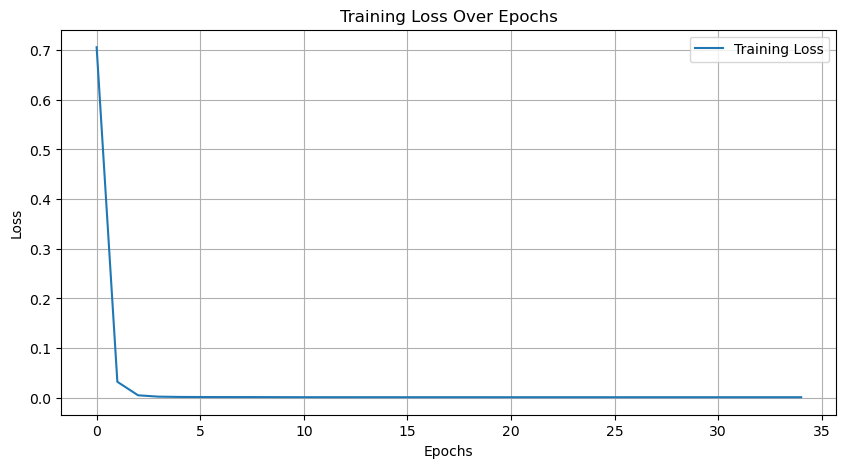

In [158]:
plt.figure(figsize=(10, 5))
#plt.plot(range(1, epochs+1), losses, marker='o', label='Training Loss')
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model

With Validation

In [160]:
def prepare_data(data, sequence_length=15):
    Xs, ys = [], []
    X, y = create_sequences(data, sequence_length)
    Xs.append(X)
    ys.append(y)
    return np.concatenate(Xs), np.concatenate(ys)

# Prepare training and validation data
sequence_length = 15
X_train, y_train = prepare_data(pd.concat([N_train_data_0, N_train_data_m1]), sequence_length)
X_val, y_val = prepare_data(N_train_data_p1, sequence_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [161]:
input_size = X.shape[2]  # Number of features
hidden_layer_size = 10  # Can be adjusted
output_size = y.shape[1]  # Prediction size (same as number of features)

model_validation = LSTMModel(input_size, hidden_layer_size, output_size)

In [162]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
epochs = 35
losses = []
val_losses = []

for epoch in range(epochs):
    model_validation.train()
    total_loss = 0
    for seq, labels in train_dataloader:
        optimizer.zero_grad()
        y_pred = model_validation(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    losses.append(avg_loss)

    # Adjust learning rate
    if epoch > 7:
        if avg_loss > 0.9 * losses[-2]:
            learning_rate /= 2
            optimizer = torch.optim.Adam(model_validation.parameters(), lr=learning_rate)

    # Validation loss
    model_validation.eval()
    with torch.no_grad():
        total_val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq)
            val_loss = criterion(y_pred, labels)
            total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_loss}, Validation Loss: {avg_val_loss}')


Epoch 1, Training Loss: 2.231872674274445, Validation Loss: 0.0015768051394232316
Epoch 2, Training Loss: 2.2301216673851014, Validation Loss: 0.0015768051394232316
Epoch 3, Training Loss: 2.2301297018051147, Validation Loss: 0.0015768051394232316
Epoch 4, Training Loss: 2.2311735218048097, Validation Loss: 0.0015768051394232316
Epoch 5, Training Loss: 2.2314008257865905, Validation Loss: 0.0015768051394232316
Epoch 6, Training Loss: 2.2304963807106017, Validation Loss: 0.0015768051394232316
Epoch 7, Training Loss: 2.2310552797317507, Validation Loss: 0.0015768051394232316
Epoch 8, Training Loss: 2.23167481379509, Validation Loss: 0.0015768051394232316
Epoch 9, Training Loss: 2.2305913007736207, Validation Loss: 0.0015768051394232316
Epoch 10, Training Loss: 0.6281423475563526, Validation Loss: 0.0015768051394232316
Epoch 11, Training Loss: 0.07308365985751152, Validation Loss: 0.0015768051394232316
Epoch 12, Training Loss: 0.02670683932751417, Validation Loss: 0.0015768051394232316
Ep

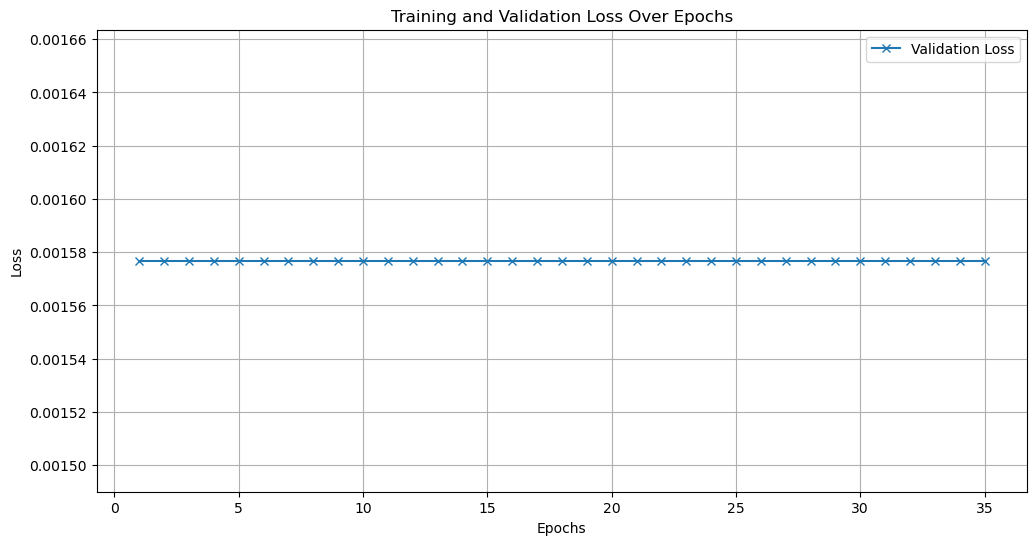

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), losses, marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [166]:
MODEL_VAL = model_validation

In [169]:
model_parameters = {}
for name, param in MODEL_VAL.named_parameters():
    model_parameters[name] = param.detach().numpy()

In [173]:
# Assuming 'model' is your trained model instance
for name, param in MODEL_VAL.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param}")
    # Convert parameter to DataFrame
    df = pd.DataFrame(param.detach().cpu().numpy())
    # Save to CSV
    df.to_csv(f"{name}_weights.csv", index=False)

Layer: lstm.weight_ih_l0 | Size: torch.Size([40, 6]) | Values: Parameter containing:
tensor([[ 0.1706, -0.3284,  0.4000, -0.0864, -0.0630,  0.2551],
        [ 0.3609, -0.0484,  0.1240, -0.0212, -0.1942,  0.0534],
        [ 0.2372,  0.0596,  0.0581, -0.0667, -0.1480,  0.1461],
        [ 0.1861,  0.0524, -0.0500,  0.3655,  0.3809,  0.0867],
        [ 0.3142,  0.1552,  0.0146, -0.0211,  0.1777,  0.2295],
        [ 0.3903,  0.3564, -0.0831,  0.2017, -0.1151, -0.2095],
        [ 0.1078,  0.1208,  0.0875, -0.0645,  0.0761, -0.5648],
        [ 0.1513,  0.1070,  0.1581, -0.0950,  0.1005,  0.1779],
        [ 0.0203,  0.0959,  0.0343, -0.1143,  0.1453,  0.2958],
        [-0.0711, -0.1230,  0.1851, -0.0698,  0.3058,  0.0548],
        [-0.0762,  0.2037, -0.1258, -0.0645,  0.0012,  0.0080],
        [ 0.1034, -0.2316, -0.0956, -0.0107, -0.4934,  0.2435],
        [-0.0544,  0.0874,  0.0203, -0.0794,  0.0055,  0.1508],
        [ 0.0895, -0.0043, -0.0014,  0.0147,  0.1596, -0.1423],
        [ 0.2859,  